In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('train_clf.csv')

In [3]:
test_data = pd.read_csv('test_clf.csv')

In [4]:
y_1 = df['y']
columns = ['a','b','c']
x_o = df[columns].values
x_means = x_o.mean(axis=0)
x_1 = (x_o - x_means)

In [5]:
with pm.Model() as model_1: 
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=len(columns)) 
     
    μ = α_tmp + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    α = pm.Deterministic('α', α_tmp - pm.math.dot(β,x_means))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * (x_1[:,0]+x_means[0]))
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(1000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [6]:
varnames = ['α','β','bd']
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,-0.656,0.734,-2.021,0.697,0.017,0.013,1929.0,1798.0,1.0
β[0],-2.285,1.218,-4.446,0.091,0.034,0.024,1249.0,1702.0,1.0
β[1],-1.865,1.204,-4.079,0.422,0.035,0.025,1165.0,1777.0,1.0
β[2],0.002,1.104,-2.062,2.047,0.034,0.024,1074.0,1665.0,1.0
θ[0],0.001,0.003,0.000,0.004,0.000,0.000,2245.0,2024.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],13.435,177.883,-14.239,28.570,2.818,1.993,1847.0,1975.0,1.0
bd[96],-1.289,144.001,-11.555,21.591,2.297,1.625,1895.0,2044.0,1.0
bd[97],-4.648,217.264,-20.216,30.531,3.461,2.448,1868.0,2066.0,1.0
bd[98],18.110,279.900,-19.288,47.842,4.439,3.139,1838.0,2032.0,1.0


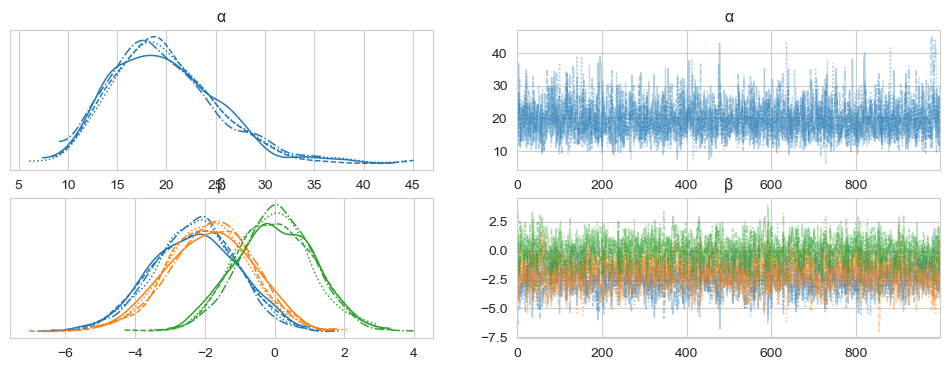

In [7]:
# Внимание!!! Компактная отрисовка. Все переменные с одним имененм на одном графике!!!
az.plot_trace(trace_1, var_names = ['α','β'],compact=True);

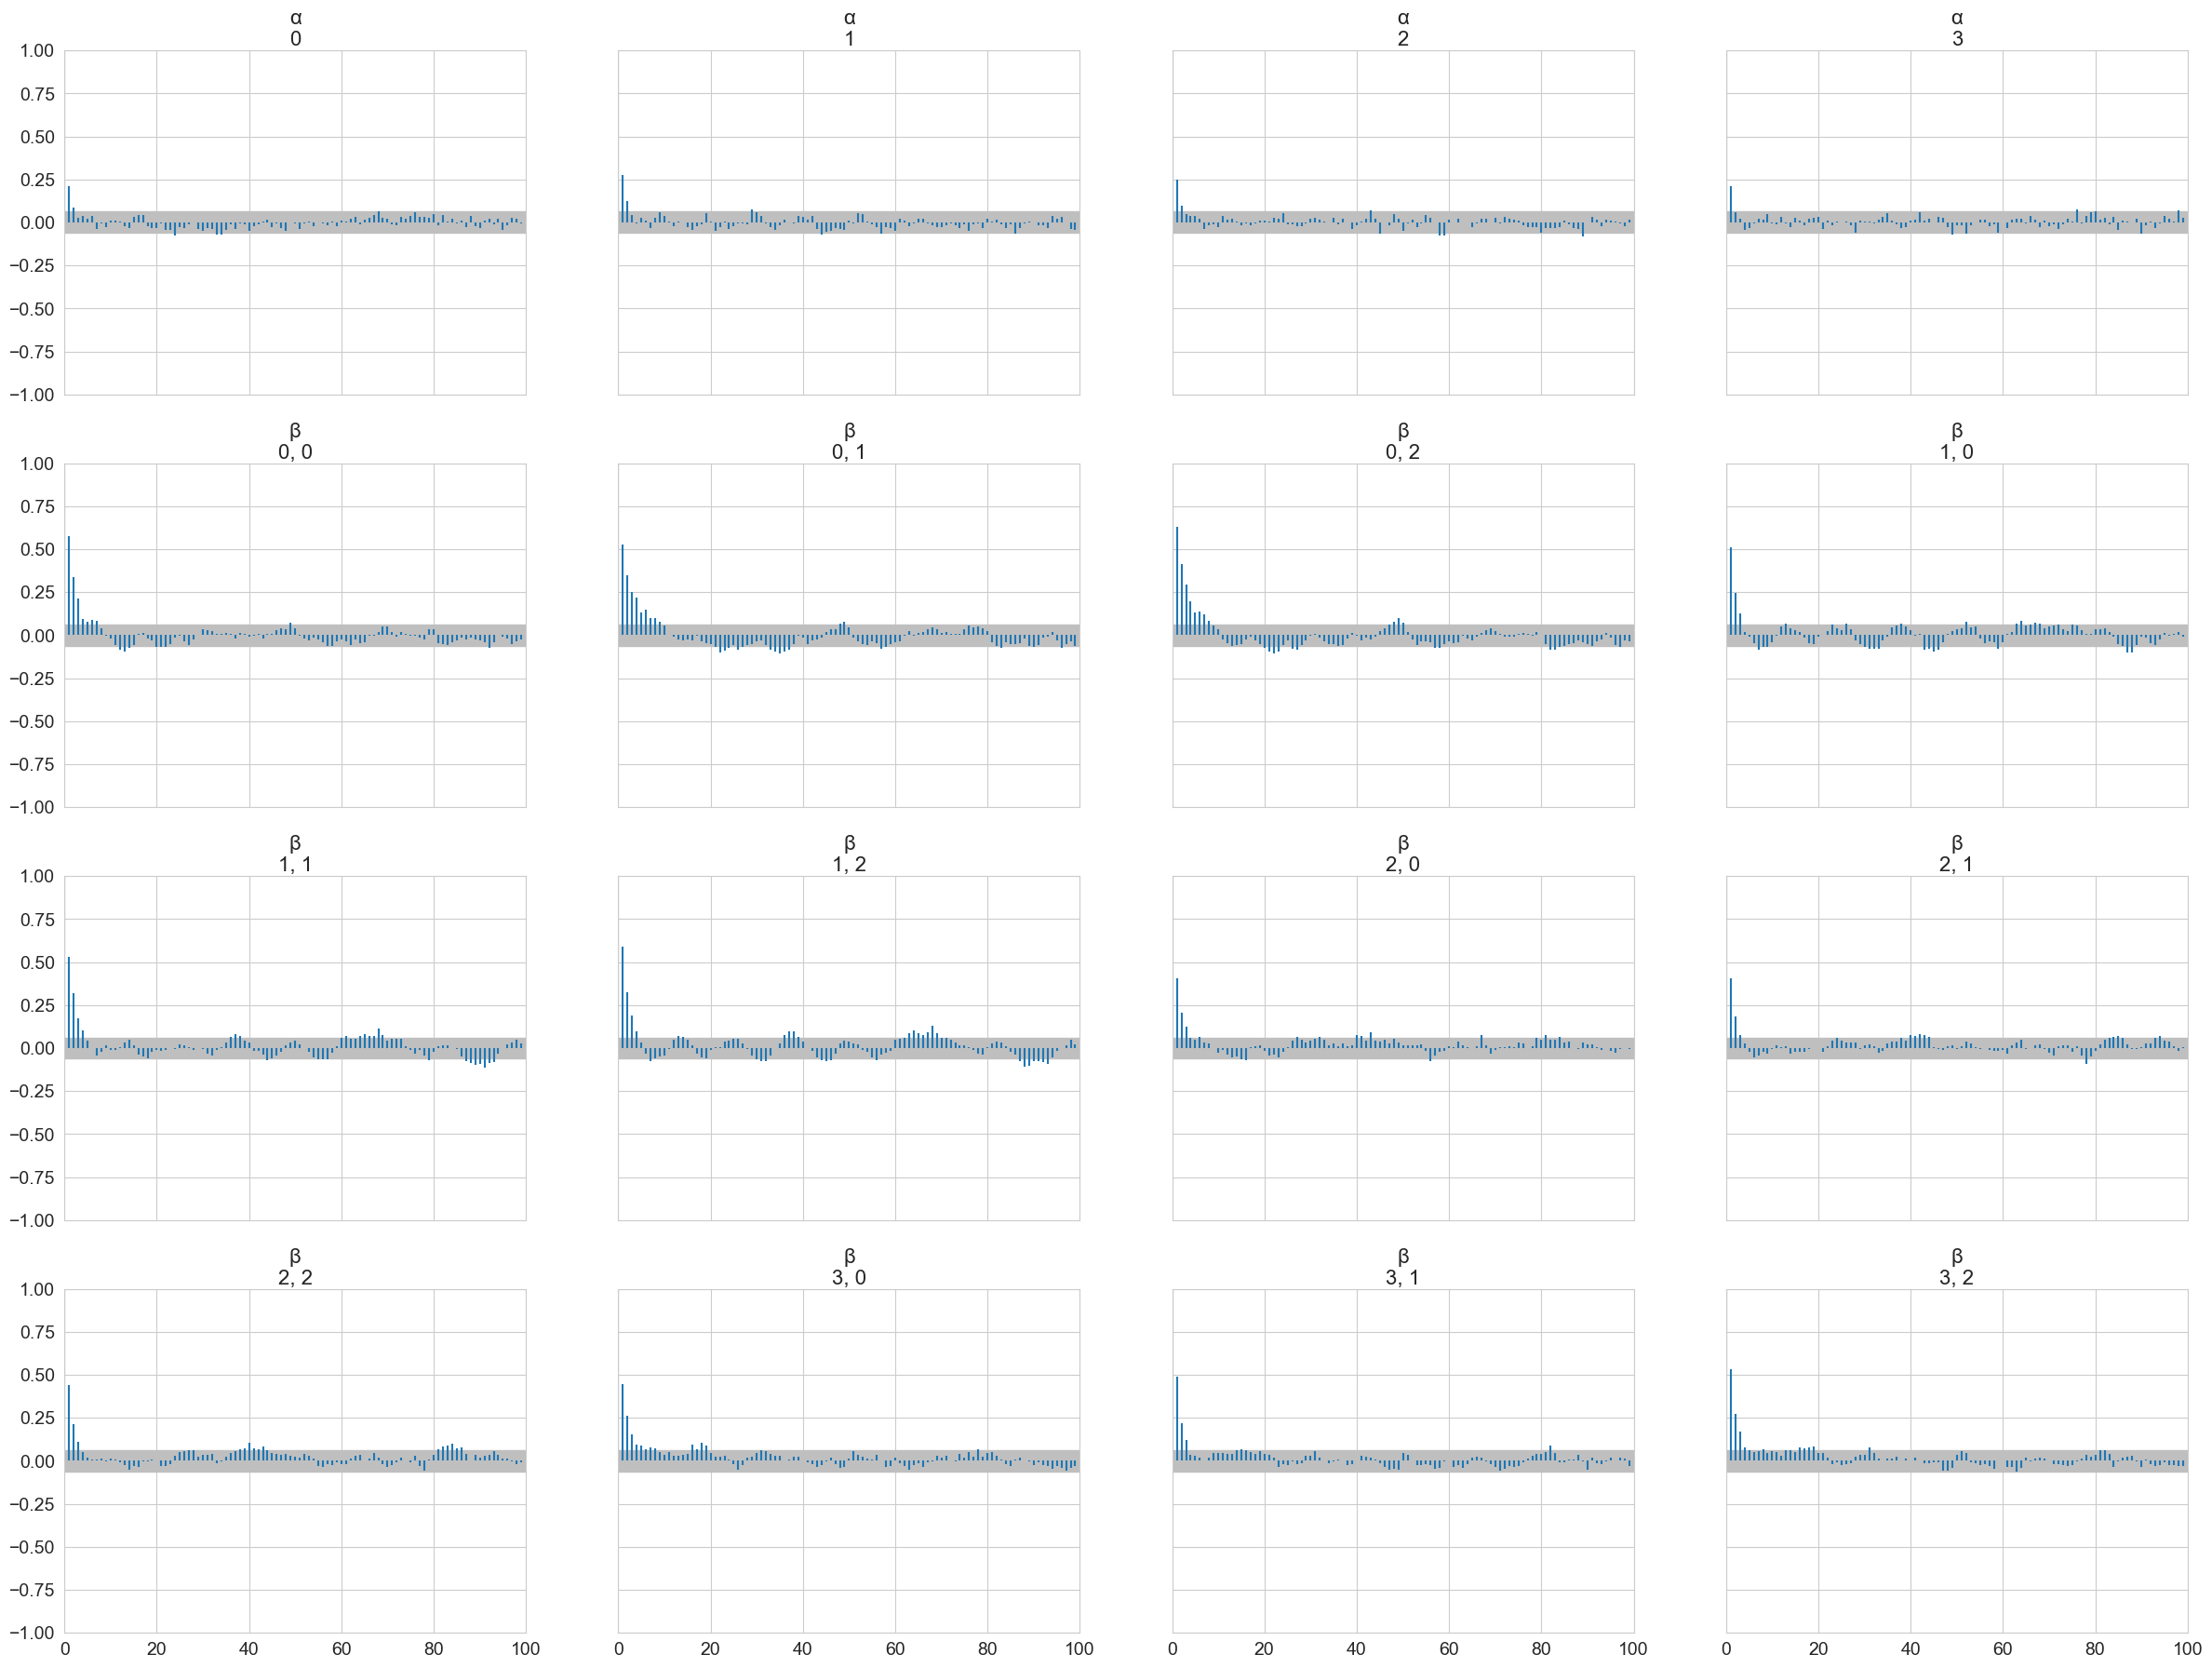

In [8]:
az.plot_autocorr(trace_1, ['α', 'β']);

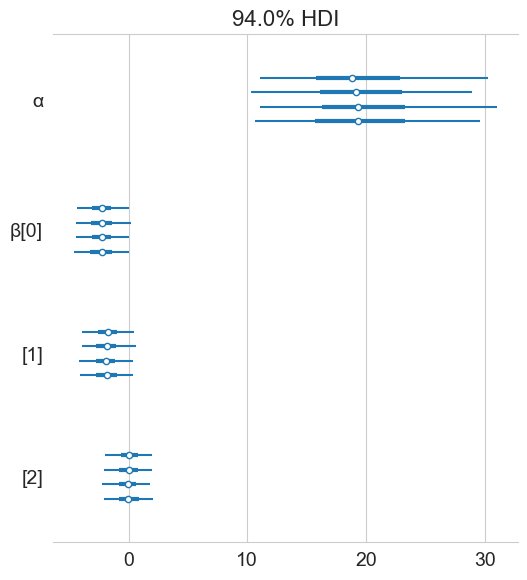

In [9]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames);

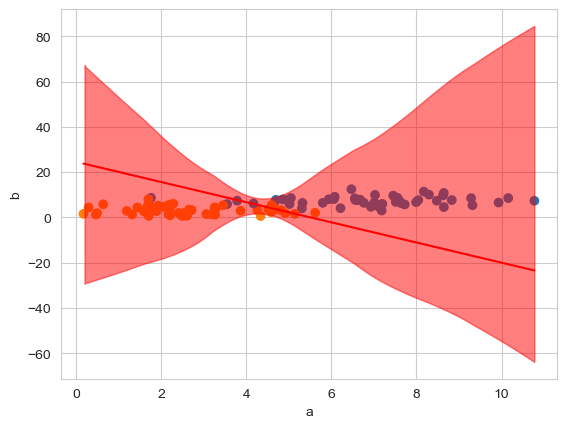

In [10]:
idx = np.argsort(x_1[:,0]) 
bd = trace_1.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x_o[:,0], x_o[:,1], c=[f'C{i}' for i in y_1.astype(int)]) 

plt.plot(x_o[:,0][idx], bd, color='r'); 
az.plot_hdi(x_o[:,0], trace_1.posterior['bd'], color='r')
 
plt.xlabel(columns[0]);
plt.ylabel(columns[1]);

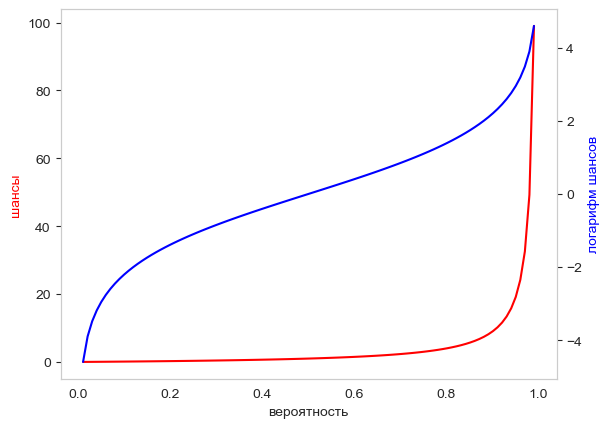

In [11]:
probability = np.linspace(0.01, 0.99, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'r')
ax2.plot(probability, np.log(odds), 'b')

ax1.set_xlabel('вероятность')
ax1.set_ylabel('шансы', color='r')
ax2.set_ylabel('логарифм шансов', color='b')
ax1.grid(False)
ax2.grid(False)

In [12]:
az.summary(trace_1, var_names=['α','β'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,19.853,5.469,11.035,30.273,0.115,0.089,2571.0,1986.0,1.0
β[0],-2.285,1.218,-4.446,0.091,0.034,0.024,1249.0,1702.0,1.0
β[1],-1.865,1.204,-4.079,0.422,0.035,0.025,1165.0,1777.0,1.0
β[2],0.002,1.104,-2.062,2.047,0.034,0.024,1074.0,1665.0,1.0


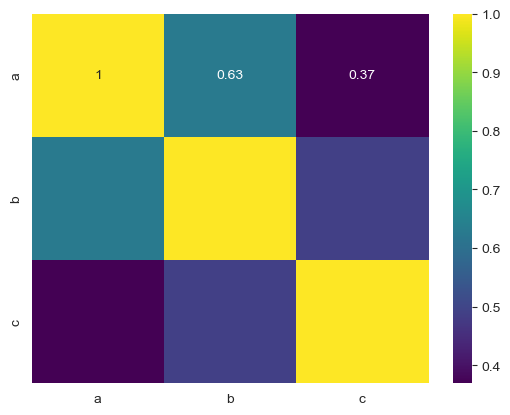

In [13]:
corr =df[columns].corr()
sns.heatmap(corr.abs(), annot=True, cmap='viridis');

In [14]:
alpha_est = np.mean(az.extract(trace_1)['α']).item()
beta_est = az.extract(trace_1)['β'].values.mean(axis=1)

print(f'alpha_est: {alpha_est}')
print(f'beta_est: {beta_est}')

alpha_est: 19.85271105059805
beta_est: [-2.28514445e+00 -1.86498800e+00  2.14618200e-03]


In [15]:
alpha = trace_1.posterior['α'].mean(("chain", "draw")).values
beta = trace_1.posterior["β"].mean(("chain", "draw")).values
data_pred = alpha + np.dot(test_data[columns], beta)
predicted_probabilities = 1 / (1 + np.exp(-data_pred))
y_pred = (predicted_probabilities > 0.5).astype(int)

In [16]:
y_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [17]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.96

In [18]:
pd.Series(y_pred).to_csv('clf_predict_Bezuglova.csv')

In [19]:
y_0 = df['y']
columns = ['a','b','c']
x_o = df[columns].values
x_means = x_o.mean(axis=0)
x_1 = (x_o - x_means)
column = 'a'
x_0 = df[column].values

In [20]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    setosa = pm.Normal('setosa', mu=μ[0], sigma=σ[0], observed=x_0[:50]) 
    versicolor = pm.Normal('versicolor', mu=μ[1], sigma=σ[1], observed=x_0[50:]) 
    
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


Text(0.5, 0, 'a')

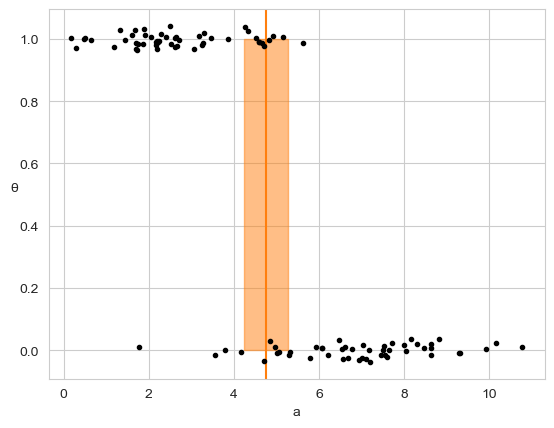

In [21]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('a')

In [22]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],4.938,0.413,4.157,5.714,0.004,0.003,11358.0,6356.0,1.0
μ[1],4.549,0.365,3.835,5.212,0.003,0.002,12034.0,6212.0,1.0
σ[0],2.916,0.314,2.381,3.531,0.003,0.002,11808.0,7004.0,1.0
σ[1],2.545,0.272,2.057,3.062,0.003,0.002,12205.0,6492.0,1.0
bd,4.744,0.277,4.239,5.271,0.003,0.002,11979.0,6357.0,1.0


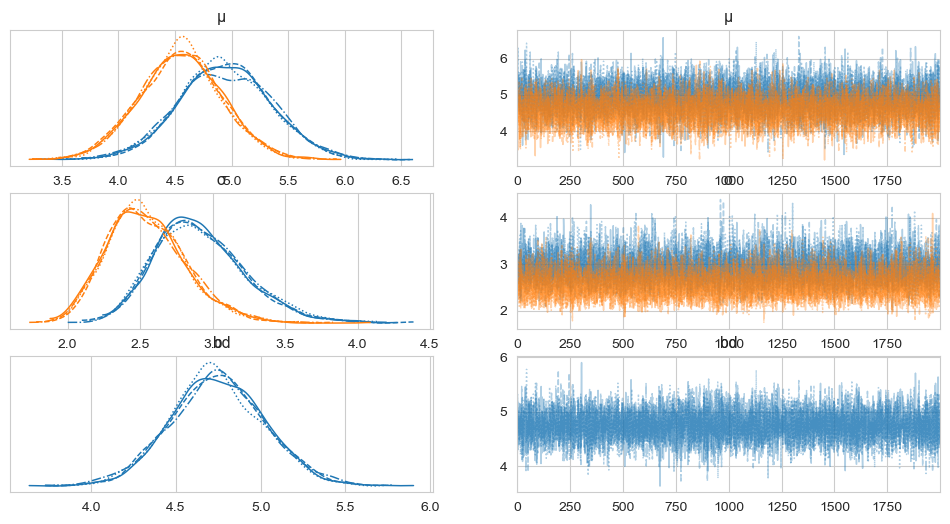

In [23]:
az.plot_trace(trace_lda,compact=True);